In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns; sns.set()
sns.set_style("ticks")
import matplotlib.pyplot as plt

custom_palette = ["red", "green", "orange", "blue", "black"]
sns.set_palette(custom_palette)

calib_method = 'logx_logreg'


args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval_manuscript/plots', 'paper_plots'),
        'eval_fold':  'eval',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men', 'overall': 'Overall'} 
       }
os.makedirs(args['plot_path'], exist_ok=True)

save_plots=True

In [2]:
aggregate_path_all = '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/experiments/bmj_manuscript/'

plot_df_all = pd.read_csv(os.path.join(aggregate_path_all, 'bootstrap_standard_eval.csv'))

In [249]:
model_type_names = {'original_pce': 'PCE',
                    'revised_pce': 'rPCE',
                    'erm': 'BL',
                    'recalib_erm': 'rBL',
                    'eqodds_thr': 'EO'
                   }

metric_names = {'auc':                    'AUC', 
                'auprc':                  'AUPRC',
                'ace_rmse_logistic_log':  'ACE',
                'loss_bce':               'loss',
                'recall_0.075':           'Sensitivity (t=7.5%)',
                'recall_0.2':             'Sensitivity (t=20%)',
                'specificity_0.075':      'Specificity (t=7.5%)',
                'specificity_0.2':        'Specificity (t=20%)',
                'observation_rate_0.075': 'Implied threshold (t=7.5%)',
                'observation_rate_0.2':   'Implied threshold (t=20%)'
                
               }

# group_names = {'overall': 'overall',
#                '1': 'Black Women', 
#                '2': 'White Women', 
#                '3': 'Black Men', 
#                '4': 'White Men'
#               }

plot_x = {'auc': 0, 'auprc': 0, 
          'recall_0.075': 1, 'recall_0.2': 1,
          'specificity_0.075': 2, 'specificity_0.2': 2,
          'observation_rate_0.075': 3, 'observation_rate_0.2': 3}

plot_y = {'auc': 0, 'auprc': 1, 
          'recall_0.075': 0, 'recall_0.2': 1,
          'specificity_0.075': 0, 'specificity_0.2': 1,
          'observation_rate_0.075': 0, 'observation_rate_0.2': 1}

#plot_y = {'AUC': 0, 'AUPRC': 1, 'specificity_0.075': 0, 'specificity_0.2': 1}

plot_df = (plot_df_all.assign(model_type = lambda x: x.model_type.map(model_type_names),
                              metric = lambda x: x.metric.map(metric_names),
                              #group = lambda x: x.group.map(group_names)
                                )
               #.query("metric == ['AUC', 'AUPRC', 'specificity_0.075', 'specificity_0.2']")
              )

model_type = np.where((plot_df.model_type=='EO') & (plot_df.model_id=='0.1'), 'mEO', plot_df.model_type)
model_type = np.where((plot_df.model_type=='EO') & (plot_df.model_id=='1.0'), 'sEO', model_type)


plot_df.model_type = pd.Categorical(model_type, 
                      categories=['PCE', 'rPCE', 'BL', 'rBL', 'mEO', 'sEO'],
                      ordered=True)




In [79]:
import os
args = {'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts'}
experiment = 'apr14_erm'
aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                      experiment, 'performance',
                                      'all')
preds_path = os.path.join(aggregate_path, 'predictions.csv')
preds = pd.read_csv(preds_path)

In [86]:
N_all = (preds
 .query("phase=='test'")
 .filter(['person_id'])
 .count()
 .person_id
)

In [250]:
eqodds_df1=(plot_df
               .query("metric!=['AUC', 'AUPRC']")
               .query("metric != ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)']")
               .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper'])
               .pivot(index=['model_type', 'metric'], columns='group', values='CI_med')
               .reset_index()
               .assign(BW = lambda x: (x['1']-x['overall'])**2,
                       WW = lambda x: (x['2']-x['overall'])**2,
                       BM = lambda x: (x['3']-x['overall'])**2,
                       WM = lambda x: (x['4']-x['overall'])**2,
                      diff_sum =lambda x: x['BW']+x['WW']+ x['BM']+x['WM'])
                .set_index(['model_type', 'metric'])
                [['diff_sum']].div(N_all)
                .pow(0.5)
)

In [251]:
eqodds_df2 = (plot_df
 .query("metric!=['AUC', 'AUPRC']")
 .query("metric != ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)'] & group=='overall'")
               .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper', 'group'])
 .reset_index(drop=True)
 .set_index(['model_type', 'metric'])
)

In [252]:
(pd.DataFrame(eqodds_df1.diff_sum/eqodds_df2.CI_med)
 .fillna(0)
 .reset_index()
 .groupby('model_type')
 .mean()
)

,0
model_type,
BL,0.000992
PCE,0.001799
mEO,0.000931
rBL,0.001890
rPCE,0.001723
sEO,0.000544


In [229]:
eqodds_viol = (plot_df
               .query("metric!=['AUC', 'AUPRC']")
               .query("metric != ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)']")
               .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper'])
               .pivot(index=['model_type', 'metric'], columns='group', values='CI_med')
               .reset_index()
               .assign(BW = lambda x: (x['1']-x['overall'])**2,
                       WW = lambda x: (x['2']-x['overall'])**2,
                       BM = lambda x: (x['3']-x['overall'])**2,
                       WM = lambda x: (x['4']-x['overall'])**2,
                      diff_sum =lambda x: x['BW']+x['WW']+ x['BM']+x['WM'])
                .set_index(['model_type', 'metric'])
                [['diff_sum']].div(N_all)
                .pow(0.5)
                .reset_index()
                .groupby('model_type')
                .mean()
               .rename(columns={'diff_sum': 'Equalized odds violation'})
)

In [230]:
calib_viol = (plot_df
              .query("metric == ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)']")
              .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper'])
              .pivot(index=['model_type', 'metric'], columns='group', values='CI_med')
              .reset_index()
              .assign(BW = lambda x: (x['1']-x['overall'])**2,
                      WW = lambda x: (x['2']-x['overall'])**2,
                      BM = lambda x: (x['3']-x['overall'])**2,
                      WM = lambda x: (x['4']-x['overall'])**2,
                      diff_sum =lambda x: x['BW']+x['WW']+ x['BM']+x['WM'])
              .set_index(['model_type', 'metric'])
              [['diff_sum']].div(N_all)
              .pow(0.5)
              .reset_index()
              .groupby('model_type')
              .mean()
              .rename(columns={'diff_sum': 'Equal calibration violation'})
)

In [231]:
violations = (eqodds_viol
              .join(calib_viol)
              .round(4)
             )

In [253]:
violations

group,Equalized odds violation,Equal calibration violation
model_type,,
PCE,0.0011,0.0003
rPCE,0.0010,0.0005
BL,0.0006,0.0002
rBL,0.0010,0.0002
mEO,0.0005,0.0003
sEO,0.0003,0.0007


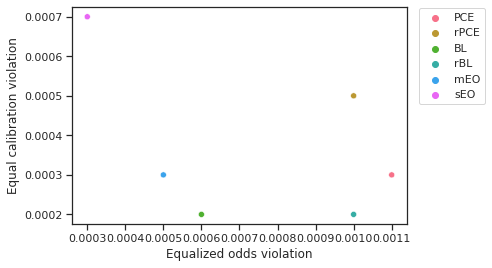

In [235]:
g = sns.scatterplot(x='Equalized odds violation', y='Equal calibration violation', data=violations, hue='model_type')
#g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02))



In [255]:
 (plot_df
               .query("metric!=['AUC', 'AUPRC']")
               .query("metric != ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)']")
               .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper'])
               .pivot(index=['model_type', 'metric'], columns='group', values='CI_med')
               .reset_index()
               .assign(BW = lambda x: (x['1']-x['overall'])**2,
                       WW = lambda x: (x['2']-x['overall'])**2,
                       BM = lambda x: (x['3']-x['overall'])**2,
                       WM = lambda x: (x['4']-x['overall'])**2,
                      diff_sum =lambda x: x['BW']+x['WW']+ x['BM']+x['WM'])
                .set_index(['model_type', 'metric'])
                [['diff_sum']].div(N_all)
                .pow(0.5)
#                 .reset_index()
#                 .groupby('model_type')
#                 .mean()
#                .rename(columns={'diff_sum': 'Equalized odds violation'})
)

group                            diff_sum
model_type metric                        
PCE        Sensitivity (t=20%)   0.000741
           Sensitivity (t=7.5%)  0.000902
           Specificity (t=20%)   0.000688
           Specificity (t=7.5%)  0.002084
rPCE       Sensitivity (t=20%)   0.000567
           Sensitivity (t=7.5%)  0.001206
           Specificity (t=20%)   0.000397
           Specificity (t=7.5%)  0.001918
BL         Sensitivity (t=20%)   0.000503
           Sensitivity (t=7.5%)  0.000270
           Specificity (t=20%)   0.000384
           Specificity (t=7.5%)  0.001271
rBL        Sensitivity (t=20%)   0.001747
           Sensitivity (t=7.5%)  0.000346
           Specificity (t=20%)   0.000589
           Specificity (t=7.5%)  0.001168
mEO        Sensitivity (t=20%)   0.000508
           Sensitivity (t=7.5%)  0.000388
           Specificity (t=20%)   0.000254
           Specificity (t=7.5%)  0.000922
sEO        Sensitivity (t=20%)   0.000000
           Sensitivity (t=7.5%)  0.000569
           Specificity (t=20%)   0.000008
           Specificity (t=7.5%)  0.000797

In [256]:
(plot_df
              .query("metric == ['Implied threshold (t=20%)', 'Implied threshold (t=7.5%)']")
              .drop(columns=['phase', 'model_id', 'CI_lower', 'CI_upper'])
              .pivot(index=['model_type', 'metric'], columns='group', values='CI_med')
              .reset_index()
              .assign(BW = lambda x: (x['1']-x['overall'])**2,
                      WW = lambda x: (x['2']-x['overall'])**2,
                      BM = lambda x: (x['3']-x['overall'])**2,
                      WM = lambda x: (x['4']-x['overall'])**2,
                      diff_sum =lambda x: x['BW']+x['WW']+ x['BM']+x['WM'])
              .set_index(['model_type', 'metric'])
              [['diff_sum']].div(N_all)
              .pow(0.5)
#               .reset_index()
#               .groupby('model_type')
#               .mean()
#               .rename(columns={'diff_sum': 'Equal calibration violation'})
)

group                                  diff_sum
model_type metric                              
PCE        Implied threshold (t=20%)   0.000441
           Implied threshold (t=7.5%)  0.000082
rPCE       Implied threshold (t=20%)   0.000836
           Implied threshold (t=7.5%)  0.000239
BL         Implied threshold (t=20%)   0.000373
           Implied threshold (t=7.5%)  0.000065
rBL        Implied threshold (t=20%)   0.000408
           Implied threshold (t=7.5%)  0.000038
mEO        Implied threshold (t=20%)   0.000419
           Implied threshold (t=7.5%)  0.000140
sEO        Implied threshold (t=20%)   0.001208
           Implied threshold (t=7.5%)  0.000158

In [41]:
(plot_df
 .query("(phase=='test') ")
 .drop(columns=['x_axis', 'y_axis', 'model_id', 'phase', 'CI_lower', 'CI_upper'])
 .pivot(index=['metric', 'group'], columns=['model_type'], values='CI_med')
 .tail(30)
)

model_type                                   PCE      rPCE        BL  \
metric                     group                                       
Implied threshold (t=20%)  Black Men    0.121949  0.148337  0.165940   
                           Black Women  0.124702  0.189802  0.195027   
                           White Men    0.149782  0.224689  0.221349   
                           White Women  0.205706  0.319474  0.241506   
                           overall      0.149428  0.211674  0.208182   
Implied threshold (t=7.5%) Black Men    0.043603  0.059743  0.072709   
                           Black Women  0.041187  0.069668  0.060724   
                           White Men    0.042760  0.076385  0.061561   
                           White Women  0.056794  0.108364  0.061579   
                           overall      0.046012  0.077595  0.063492   
Sensitivity (t=20%)        Black Men    0.317979  0.224964  0.317538   
                           Black Women  0.398467  0.231606  0.364195   
                           White Men    0.463542  0.313322  0.421342   
                           White Women  0.433949  0.204835  0.350694   
                           overall      0.418867  0.256294  0.371868   
Sensitivity (t=7.5%)       Black Men    0.967882  0.840920  0.809201   
                           Black Women  0.828989  0.728054  0.796025   
                           White Men    0.945091  0.807967  0.849119   
                           White Women  0.812600  0.602048  0.812478   
                           overall      0.895340  0.746470  0.822826   
Specificity (t=20%)        Black Men    0.827418  0.904284  0.889251   
                           Black Women  0.892980  0.965054  0.939394   
                           White Men    0.826120  0.933409  0.911111   
                           White Women  0.951009  0.981736  0.965379   
                           overall      0.883065  0.951867  0.932162   
Specificity (t=7.5%)       Black Men    0.387050  0.515673  0.599338   
                           Black Women  0.644403  0.775518  0.751634   
                           White Men    0.404498  0.608784  0.548440   
                           White Women  0.755436  0.886660  0.774299   
                           overall      0.572648  0.724032  0.677746   

model_type                                   rBL       mEO       sEO  
metric                     group                                      
Implied threshold (t=20%)  Black Men    0.236415  0.184677  0.585056  
                           Black Women  0.237235  0.203826  0.806852  
                           White Men    0.187702  0.264115  0.746879  
                           White Women  0.257537  0.243167  0.801948  
                           overall      0.212117  0.230363  0.756058  
Implied threshold (t=7.5%) Black Men    0.081105  0.069754  0.048681  
                           Black Women  0.075627  0.044999  0.023833  
                           White Men    0.080529  0.062242  0.046930  
                           White Women  0.083213  0.045463  0.023580  
                           overall      0.079173  0.055631  0.036385  
Sensitivity (t=20%)        Black Men    0.156856  0.255851  0.000000  
                           Black Women  0.263882  0.300386  0.000000  
                           White Men    0.503242  0.354882  0.000000  
                           White Women  0.330990  0.310916  0.000000  
                           overall      0.358150  0.321822  0.000000  
Sensitivity (t=7.5%)       Black Men    0.777857  0.840948  0.937775  
                           Black Women  0.793579  0.796025  1.000000  
                           White Men    0.821765  0.848700  0.902921  
                           White Women  0.748805  0.877264  0.937889  
                           overall      0.785578  0.845896  0.918839  
Specificity (t=20%)        Black Men    0.949206  0.913462  1.000000  
                           Black Women  0.966814  0.947712  1.

In [29]:
(plot_df
 .query("(phase=='test') & (metric=='AUPRC') ")
 .drop(columns=['x_axis', 'y_axis', 'model_id', 'phase', 'CI_lower', 'CI_upper'])
 .groupby(['metric', 'model_type', 'group']).sum()
 .head(30)
)

CI_med
metric model_type group                
AUPRC  PCE        Black Men    0.143852
                  Black Women  0.220273
                  White Men    0.274448
                  White Women  0.322629
                  overall      0.228237
       rPCE       Black Men    0.154815
                  Black Women  0.219068
                  White Men    0.269768
                  White Women  0.309392
                  overall      0.218872
       BL         Black Men    0.192967
                  Black Women  0.290956
                  White Men    0.373371
                  White Women  0.334802
                  overall      0.284277
       rBL        Black Men    0.192967
                  Black Women  0.290956
                  White Men    0.373371
                  White Women  0.334802
                  overall      0.305136
       mEO        Black Men    0.198490
                  Black Women  0.298321
                  White Men    0.380006
                  White Women  0.334538
                  overall      0.287531
       sEO        Black Men    0.212532
                  Black Women  0.265422
                  White Men    0.325339
                  White Women  0.294644
                  overall      0.264931